# Building a Draft Model
### Objectives
- Building a vor draft model for a snake draft (2022 Fantasy Football Season)
- Calculate the value over replacement for each player
- Include ADP (average draft position) data

### Importing Libraries

In [1]:
# imports
import pandas as pd
from bs4 import BeautifulSoup as BS
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

### Loading and showing the Data

In [2]:
#loading the data
df = pd.read_csv('https://raw.githubusercontent.com/JanisLS/FantasyDraft2022/main/Data/all_compiled.csv',
                 index_col=0,
                 sep=",")

# removing extra characters in player names to prepare data for merging
df['Player'] = df['Player'].apply(lambda x: ' '.join(x.split()[:2]))

# removing commas from should-be float columns that are currently strings
comma_columns = ['REC_YD', 'PASS_YD', 'RUSH_YD']
for column in comma_columns:
  df[column] = df[column].apply(lambda x: x.replace(',', ''))

# converting all columns that should be floats to floats
df.iloc[:, 3:] = df.iloc[:, 3:].astype(float)

# printing the top five rows
df.head()

,Player,Team,POS,RUSH_ATT,RUSH_YD,RUSH_TD,REC,REC_YD,REC_TD,FL,PASS_ATT,CMP,PASS_YD,PASS_TD,INTS
1,Jonathan Taylor,IND,RB,326.1,1602.9,14.7,42.4,353.8,2.0,2.3,0.0,0.0,0.0,0.0,0.0
2,Derrick Henry,TEN,RB,366.2,1640.3,13.0,27.4,215.9,0.9,2.0,0.0,0.0,0.0,0.0,0.0
3,Austin Ekeler,LAC,RB,221.0,983.5,9.4,74.4,664.8,5.3,1.5,0.0,0.0,0.0,0.0,0.0
4,Christian McCaffrey,CAR,RB,238.6,1061.6,7.5,89.0,758.2,4.1,1.4,0.0,0.0,0.0,0.0,0.0
5,Joe Mixon,CIN,RB,286.8,1202.4,9.8,47.1,342.1,2.6,1.6,0.0,0.0,0.0,0.0,0.0


### Adding Projected Fantasy Points

In [3]:
# standard scoring
df['STANDARD'] = (df['RUSH_YD'] + df['REC_YD'])*0.1 + \
(df['RUSH_TD'] + df['REC_TD'])*6 + \
+ df['PASS_YD']*0.04 + df['PASS_TD']*4 + \
(df['INTS'] + df['FL'])*-2

# standard + 0.5 * receptions
# df['HALF_PPR'] = df['STANDARD'] + df['REC']*0.5

#standard + 1 * each reception
# df['PPR'] = df['STANDARD'] + df['REC']

df.head()

,Player,Team,POS,RUSH_ATT,RUSH_YD,RUSH_TD,REC,REC_YD,REC_TD,FL,PASS_ATT,CMP,PASS_YD,PASS_TD,INTS,STANDARD
1,Jonathan Taylor,IND,RB,326.1,1602.9,14.7,42.4,353.8,2.0,2.3,0.0,0.0,0.0,0.0,0.0,291.27
2,Derrick Henry,TEN,RB,366.2,1640.3,13.0,27.4,215.9,0.9,2.0,0.0,0.0,0.0,0.0,0.0,265.02
3,Austin Ekeler,LAC,RB,221.0,983.5,9.4,74.4,664.8,5.3,1.5,0.0,0.0,0.0,0.0,0.0,250.03
4,Christian McCaffrey,CAR,RB,238.6,1061.6,7.5,89.0,758.2,4.1,1.4,0.0,0.0,0.0,0.0,0.0,248.78
5,Joe Mixon,CIN,RB,286.8,1202.4,9.8,47.1,342.1,2.6,1.6,0.0,0.0,0.0,0.0,0.0,225.65


### Scraping for Average Draft Position Data

In [4]:
ADP_URL = 'https://www.fantasypros.com/nfl/adp/standard-overall.php'

res = requests.get(ADP_URL)

soup = BS(res.content, 'html.parser')

table = soup.find('table', {'id': 'data'})

adp_df = pd.read_html(str(table))[0]

#cleaning the data.
#player name, team, and bye week were all located in the same column, and so we are splitting the column up and creating seperate columns
#for player name and team and removing bye week altogether
adp_df['Team'] = adp_df['Player Team (Bye)'].apply(lambda x: x.split()[-2])
adp_df['Player'] = adp_df['Player Team (Bye)'].apply(lambda x: ' '.join(x.split()[:-2]))
# removing extra characters in player names to prepare data for merging
adp_df['Player'] = adp_df['Player'].apply(lambda x: ' '.join(x.split()[:2]))

adp_df['POS'] = adp_df['POS'].apply(lambda x: x[:2])
adp_df = adp_df.loc[:, ['Player', 'Team', 'POS', 'AVG']]

#creating a column to rank players on their ADP
adp_df['ADP_RANK'] = adp_df['AVG'].rank(method='first')

adp_df[:100].tail(15)

,Player,Team,POS,AVG,ADP_RANK
85,Hunter Renfrow,LV,WR,84.0,86.0
86,Tom Brady,TB,QB,84.0,87.0
87,Ken Walker,SEA,RB,86.3,88.0
88,DeVonta Smith,PHI,WR,88.3,89.0
89,Rhamondre Stevenson,NE,RB,90.7,90.0
90,Matthew Stafford,LAR,QB,91.3,91.0
91,Tyler Lockett,SEA,WR,94.0,92.0
92,Drake London,ATL,WR,95.0,93.0
93,DeAndre Hopkins,ARI,WR,95.0,94.0
94,Aaron Rodgers,GB,QB,95.0,95.0


### Finding the replacement players

In [5]:
replacement_players = {}
for _, row in adp_df[:100].iterrows():
  replacement_players[row['POS']] = row['Player']

print(replacement_players)

replacement_values = pd.DataFrame({
    'Player': replacement_players.values(),
    'POS': replacement_players.keys()}).merge(
    df, on=['Player', 'POS']).loc[:, ['POS', 'STANDARD']].rename({
    'STANDARD': 'REPLACEMENT_VALUE'}, axis=1)

replacement_values.head()

{'RB': 'Melvin Gordon', 'WR': 'Treylon Burks', 'TE': 'Zach Ertz', 'QB': 'Trey Lance'}


,POS,REPLACEMENT_VALUE
0,RB,129.080
1,WR,118.700
2,TE,94.290
3,QB,302.634


In [6]:
vor_df = df.loc[:, ['Player', 'POS', 'Team', 'STANDARD']].merge(replacement_values, on='POS')

vor_df['VOR'] = vor_df['STANDARD'] - vor_df['REPLACEMENT_VALUE']

vor_df.sort_values(by='VOR', ascending=False).loc[:, ['Player', 'POS', 'Team', 'STANDARD', 'VOR']].reset_index(drop=True).head(30)
                    

,Player,POS,Team,STANDARD,VOR
0,Jonathan Taylor,RB,IND,291.270,162.190
1,Derrick Henry,RB,TEN,265.020,135.940
2,Austin Ekeler,RB,LAC,250.030,120.950
3,Christian McCaffrey,RB,CAR,248.780,119.700
4,Cooper Kupp,WR,LAR,235.570,116.870
5,Joe Mixon,RB,CIN,225.650,96.570
6,Dalvin Cook,RB,MIN,220.410,91.330
7,Ja'Marr Chase,WR,CIN,209.740,91.040
8,Justin Jefferson,WR,MIN,208.680,89.980
9,Alvin Kamara,RB,NO,218.890,89.810


### Finding overdrafted and underdrafted Players

In [7]:
# loading the data
ADP_URL = 'https://www.fantasypros.com/nfl/adp/standard-overall.php'
PROJECTION_URL = 'https://raw.githubusercontent.com/fantasydatapros/2021-VOR-Model/master/data/all_compiled.csv'
df = pd.read_csv(PROJECTION_URL, index_col=0)

# removing extra characters in player names to prepare data for merging
df['Player'] = df['Player'].apply(lambda x: ' '.join(x.split()[:2]))

# removing commas from should-be float columns that are currently strings
comma_columns = ['REC_YD', 'PASS_YD', 'RUSH_YD']
for column in comma_columns:
  df[column] = df[column].apply(lambda x: x.replace(',', ''))

# converting all columns that should be floats to floats
df.iloc[:, 3:] = df.iloc[:, 3:].astype(float)
# standard scoring
df['STANDARD'] = (df['RUSH_YD'] + df['REC_YD'])*0.1 + \
(df['RUSH_TD'] + df['REC_TD'])*6 + \
+ df['PASS_YD']*0.04 + df['PASS_TD']*4 + \
(df['INTS'] + df['FL'])*-2

# standard + 0.5 * receptions
# df['HALF_PPR'] = df['STANDARD'] + df['REC']*0.5

# standard + 1 * each reception
# df['PPR'] = df['STANDARD'] + df['REC']

res = requests.get(ADP_URL)
soup = BS(res.content, 'html.parser')
table = soup.find('table', {'id': 'data'})

adp_df = pd.read_html(str(table))[0]

# cleaning the data
adp_df['Team'] = adp_df['Player Team (Bye)'].apply(lambda x: x.split()[-2])
adp_df['Player'] = adp_df['Player Team (Bye)'].apply(lambda x: ' '.join(x.split()[:-2]))

# removing extra characters in player names to prepare data for merging
adp_df['Player'] = adp_df['Player'].apply(lambda x: ' '.join(x.split()[:2]))

adp_df['POS'] = adp_df['POS'].apply(lambda x: x[:2])
adp_df = adp_df.loc[:, ['Player', 'Team', 'POS', 'AVG']]

#creating a column to rank players on their ADP
adp_df['ADP_RANK'] = adp_df['AVG'].rank(method='first')

replacement_players = {}
for _, row in adp_df[:100].iterrows():
  replacement_players[row['POS']] = row['Player']

replacement_values = pd.DataFrame({
    'Player': replacement_players.values(),
    'POS': replacement_players.keys()
}).merge(
    df, on=['Player', 'POS']
).loc[:, ['POS', 'STANDARD']].rename({
    'STANDARD': 'REPLACEMENT_VALUE'
}, axis=1)

vor_df = df.merge(replacement_values, on='POS')

vor_df['VOR'] = vor_df['STANDARD'] - vor_df['REPLACEMENT_VALUE']

vor_df = vor_df.sort_values(by='VOR', ascending=False).reset_index(drop=True)

vor_df.head()

,Player,Team,POS,RUSH_ATT,RUSH_YD,RUSH_TD,REC,REC_YD,REC_TD,FL,PASS_ATT,CMP,PASS_YD,PASS_TD,INTS,STANDARD,REPLACEMENT_VALUE,VOR
0,Christian McCaffrey,CAR,RB,297.3,1302.1,12.0,93.7,758.0,4.3,2.5,0.0,0.0,0.0,0.0,0.0,298.810,122.790,176.020
1,Dalvin Cook,MIN,RB,316.6,1487.5,12.9,55.0,473.5,2.0,2.9,0.0,0.0,0.0,0.0,0.0,279.700,122.790,156.910
2,Derrick Henry,TEN,RB,343.5,1705.8,14.1,24.4,182.6,1.1,2.7,0.0,0.0,0.0,0.0,0.0,274.640,122.790,151.850
3,Josh Allen,BUF,QB,110.7,519.5,7.6,0.0,0.0,0.0,5.1,605.6,400.6,4582.9,34.1,13.3,380.466,233.264,147.202
4,Patrick Mahomes,KC,QB,55.5,267.9,3.0,0.0,0.0,0.0,2.5,629.6,418.0,5018.8,38.8,8.9,377.942,233.264,144.678


### Joining the DataFrames

In [8]:
vor_adp_df = vor_df.merge(adp_df).assign(
    VOR_RANK=lambda x: x.VOR.rank(ascending=False)
).assign(
    OVER_UNDER_DRAFTED = lambda x: x.ADP_RANK - x.VOR_RANK
).loc[:, ['Player', 'Team', 'POS', 'VOR', 'VOR_RANK', 'ADP_RANK', 'OVER_UNDER_DRAFTED']]

with pd.option_context('display.max_rows', 100):
  display(vor_adp_df.head(100))

,Player,Team,POS,VOR,VOR_RANK,ADP_RANK,OVER_UNDER_DRAFTED
0,Christian McCaffrey,CAR,RB,176.020,1.0,2.0,1.0
1,Dalvin Cook,MIN,RB,156.910,2.0,8.0,6.0
2,Derrick Henry,TEN,RB,151.850,3.0,4.0,1.0
3,Josh Allen,BUF,QB,147.202,4.0,24.0,20.0
4,Patrick Mahomes,KC,QB,144.678,5.0,34.0,29.0
5,Travis Kelce,KC,TE,129.250,6.0,14.0,8.0
6,Kyler Murray,ARI,QB,125.438,7.0,59.0,52.0
7,Lamar Jackson,BAL,QB,120.672,8.0,51.0,43.0
8,Alvin Kamara,NO,RB,117.900,9.0,15.0,6.0
9,Dak Prescott,DAL,QB,108.682,10.0,72.0,62.0


### Exporting the Results as PDF

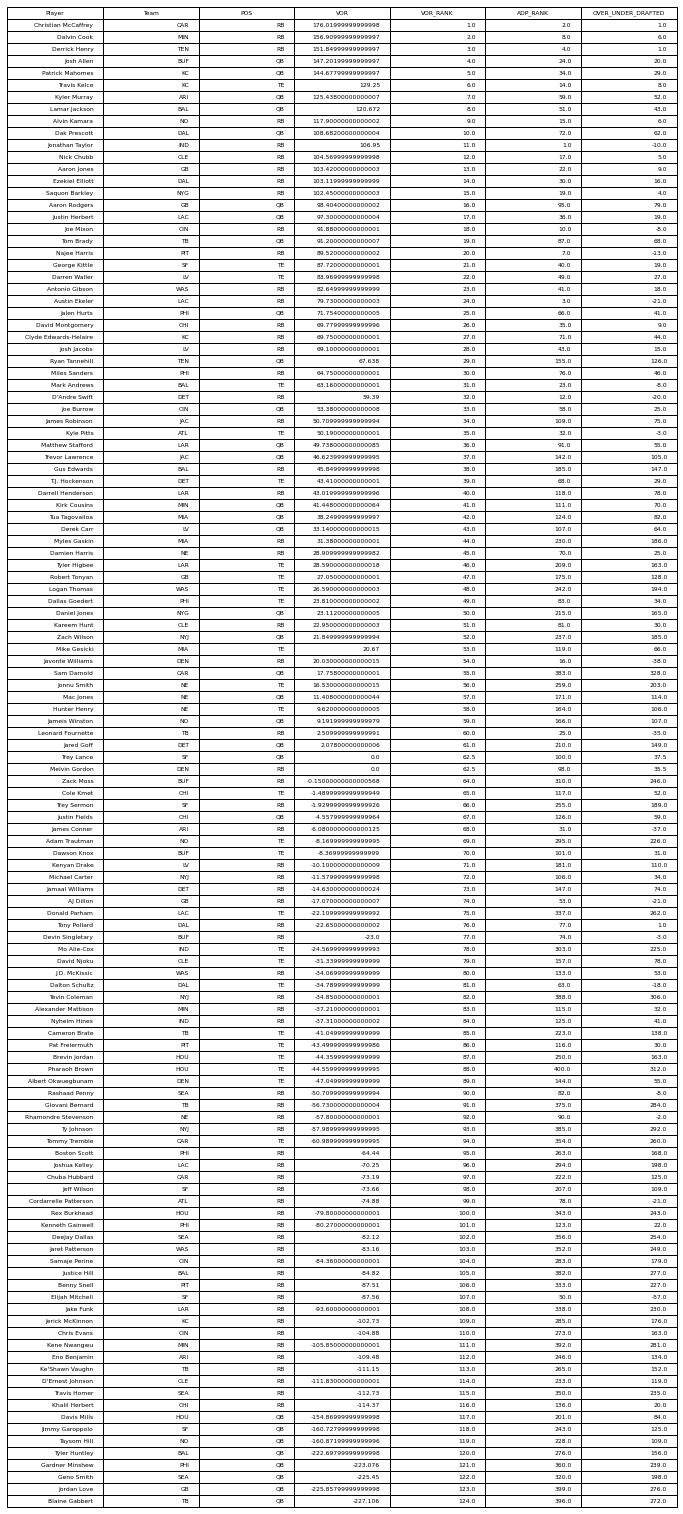

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=vor_adp_df.values,
                 colLabels=vor_adp_df.columns,loc='center')

In [10]:
pp = PdfPages("2022-08-22.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()